# README

Implement CIFER-10 image classification based on simple CNN (Acc=80%), vision transformer (Acc=98%), and convolution mixer (Acc=96%).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [3]:
import os
import argparse
import csv
import time
from models import *
from models.vit import ViT
from utils import progress_bar
from models.convmixer import ConvMixer
from randomaug import RandAugment

In [4]:
import numpy as np 
import pandas as pd

In [5]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
print(len(train_data))
print(len(test_data))

50000
10000


In [8]:
num_workers = 0
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [9]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [10]:
dataiter = iter(train_loader)

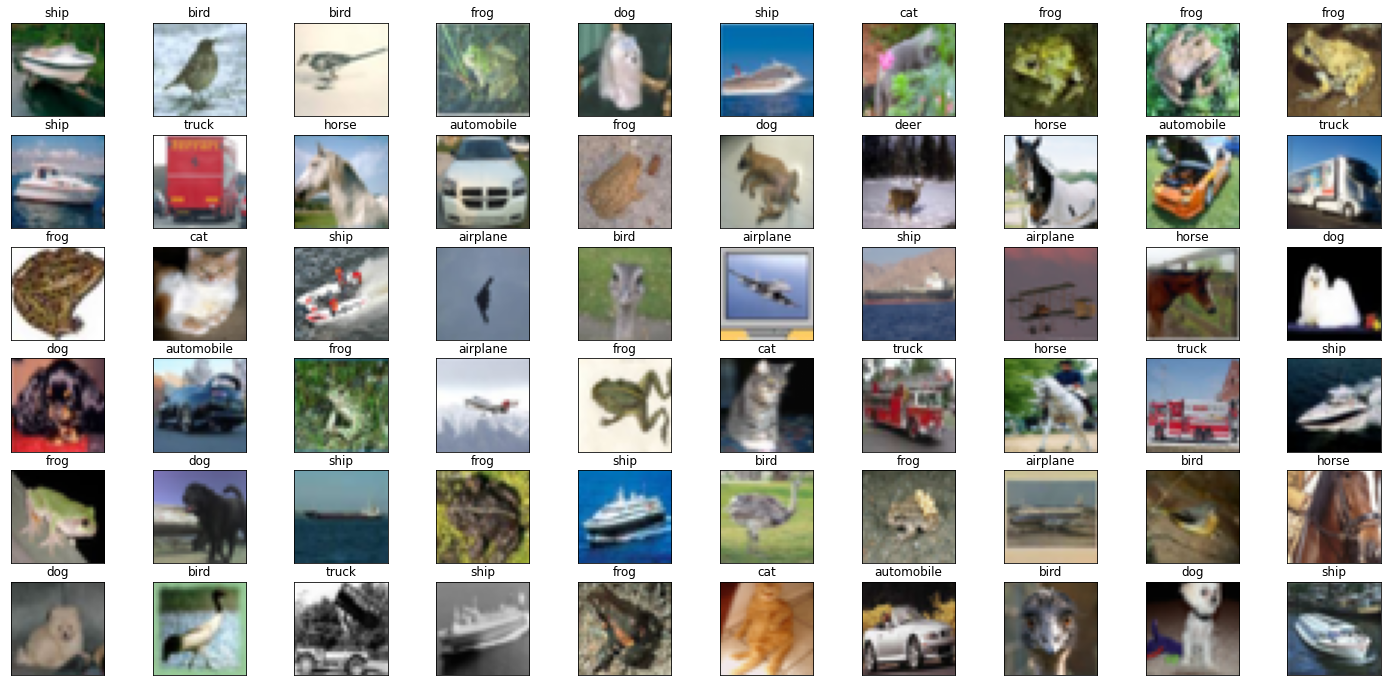

In [11]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
fig = plt.figure(figsize=(25, 12))
for i in np.arange(60):
    ax = fig.add_subplot(6, 10, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

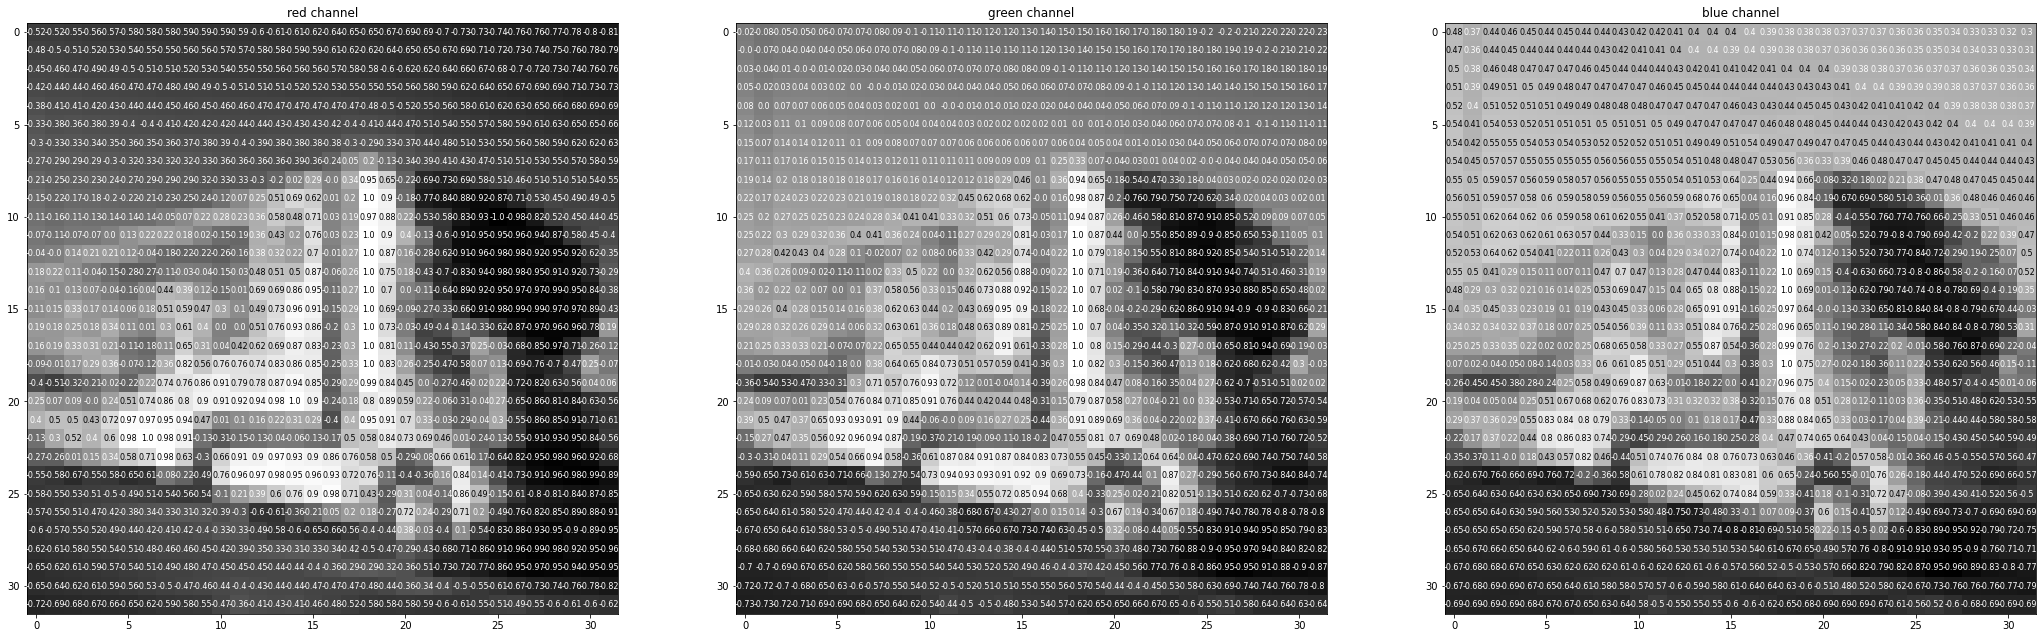

In [12]:
rgb_img = np.squeeze(images[19])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                horizontalalignment='center',
                verticalalignment='center', size=8,
                color='white' if img[x][y]<thresh else 'black')

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [15]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [16]:
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [17]:
train_losslist = []
valid_losslist = []
train_acclist = []
valid_acclist = []

for epoch in range(1, 500+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0

    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        acc = accuracy(output, target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        train_acc += acc.item()*data.size(0)

    model.eval()
    for data, target in test_loader:
        output = model(data)
        acc = accuracy(output, target)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        valid_acc += acc.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    train_acc = train_acc/len(train_loader.dataset)
    valid_acc = valid_acc/len(test_loader.dataset)
    train_losslist.append(train_loss)
    valid_losslist.append(valid_loss)
    train_acclist.append(train_acc)
    valid_acclist.append(valid_acc)
        
    print("Epoch ->", epoch, "\t train_loss ->", train_loss, "\t\t\t train_acc ->", train_acc, 
          "\n==========\t valid_loss ->", valid_loss, "\t\t\t valid_acc ->", valid_acc)
    
torch.save(model.state_dict(), 'cifar_net.pt')

Epoch -> 1 	 train_loss -> 2.303858677825928 			 train_acc -> 0.10002 
==========	 valid_loss -> 2.3027589096069336 			 valid_acc -> 0.1
Epoch -> 2 	 train_loss -> 2.3024249745178222 			 train_acc -> 0.10456000000476837 
==========	 valid_loss -> 2.301527425765991 			 valid_acc -> 0.1
Epoch -> 3 	 train_loss -> 2.3012678879547117 			 train_acc -> 0.11096 
==========	 valid_loss -> 2.3002323482513427 			 valid_acc -> 0.1034
Epoch -> 4 	 train_loss -> 2.3001058481597902 			 train_acc -> 0.11986000000476837 
==========	 valid_loss -> 2.2981351642608643 			 valid_acc -> 0.1875
Epoch -> 5 	 train_loss -> 2.2976068840026858 			 train_acc -> 0.13141999999523163 
==========	 valid_loss -> 2.293204281234741 			 valid_acc -> 0.1749
Epoch -> 6 	 train_loss -> 2.2912640962219237 			 train_acc -> 0.14088000000238418 
==========	 valid_loss -> 2.278938363265991 			 valid_acc -> 0.1706
Epoch -> 7 	 train_loss -> 2.2634745265197753 			 train_acc -> 0.15943999999046327 
==========	 valid_loss -> 2.2057

Epoch -> 56 	 train_loss -> 1.1983092890930176 			 train_acc -> 0.5703800000190735 
==========	 valid_loss -> 1.0596424001693725 			 valid_acc -> 0.6242
Epoch -> 57 	 train_loss -> 1.1886528632354736 			 train_acc -> 0.5744400000190735 
==========	 valid_loss -> 1.0638789278984069 			 valid_acc -> 0.6217
Epoch -> 58 	 train_loss -> 1.1822414262390137 			 train_acc -> 0.5778399999809265 
==========	 valid_loss -> 1.088953817176819 			 valid_acc -> 0.6132
Epoch -> 59 	 train_loss -> 1.1743196140670777 			 train_acc -> 0.5832199999904633 
==========	 valid_loss -> 1.0418786136627198 			 valid_acc -> 0.6309
Epoch -> 60 	 train_loss -> 1.1657207917404175 			 train_acc -> 0.5854800000190735 
==========	 valid_loss -> 1.041818323993683 			 valid_acc -> 0.6306
Epoch -> 61 	 train_loss -> 1.158728257369995 			 train_acc -> 0.588099999961853 
==========	 valid_loss -> 1.0522518579483031 			 valid_acc -> 0.623
Epoch -> 62 	 train_loss -> 1.1498523130989076 			 train_acc -> 0.59036 
==========	 va

Epoch -> 111 	 train_loss -> 0.8941800870895386 			 train_acc -> 0.6915000000190735 
==========	 valid_loss -> 0.7854664024353027 			 valid_acc -> 0.7324
Epoch -> 112 	 train_loss -> 0.8885718925476074 			 train_acc -> 0.69372 
==========	 valid_loss -> 0.794243579864502 			 valid_acc -> 0.7275
Epoch -> 113 	 train_loss -> 0.8867039361763001 			 train_acc -> 0.6976199999809265 
==========	 valid_loss -> 0.7889953819274902 			 valid_acc -> 0.7369
Epoch -> 114 	 train_loss -> 0.8834603238868713 			 train_acc -> 0.696099999961853 
==========	 valid_loss -> 0.7859834877967834 			 valid_acc -> 0.7282
Epoch -> 115 	 train_loss -> 0.882724671382904 			 train_acc -> 0.69782 
==========	 valid_loss -> 0.7848587103843689 			 valid_acc -> 0.7351
Epoch -> 116 	 train_loss -> 0.8754439193344116 			 train_acc -> 0.6999399999809265 
==========	 valid_loss -> 0.7829015510559082 			 valid_acc -> 0.7358
Epoch -> 117 	 train_loss -> 0.8747630624961853 			 train_acc -> 0.6992799999809265 
==========	 vali

Epoch -> 166 	 train_loss -> 0.7436459146499633 			 train_acc -> 0.7473800000190735 
==========	 valid_loss -> 0.6912722137451172 			 valid_acc -> 0.7641
Epoch -> 167 	 train_loss -> 0.741863222026825 			 train_acc -> 0.7465999999809265 
==========	 valid_loss -> 0.6903539115905761 			 valid_acc -> 0.7627
Epoch -> 168 	 train_loss -> 0.7395874258804321 			 train_acc -> 0.74904 
==========	 valid_loss -> 0.6910709829330445 			 valid_acc -> 0.7618
Epoch -> 169 	 train_loss -> 0.7367356294822693 			 train_acc -> 0.7500599999809265 
==========	 valid_loss -> 0.7003000899314881 			 valid_acc -> 0.7598
Epoch -> 170 	 train_loss -> 0.7315539638328552 			 train_acc -> 0.7498799999618531 
==========	 valid_loss -> 0.6826261349201203 			 valid_acc -> 0.7647
Epoch -> 171 	 train_loss -> 0.7293832177352906 			 train_acc -> 0.752280000038147 
==========	 valid_loss -> 0.6913561307907105 			 valid_acc -> 0.7613
Epoch -> 172 	 train_loss -> 0.7277619713401794 			 train_acc -> 0.7503600000190734 
====

Epoch -> 221 	 train_loss -> 0.6366846941280365 			 train_acc -> 0.78242 
==========	 valid_loss -> 0.627725277519226 			 valid_acc -> 0.7862
Epoch -> 222 	 train_loss -> 0.6403937614822388 			 train_acc -> 0.781779999961853 
==========	 valid_loss -> 0.6305835648536682 			 valid_acc -> 0.7837
Epoch -> 223 	 train_loss -> 0.6374712586402893 			 train_acc -> 0.784580000038147 
==========	 valid_loss -> 0.6305260099411011 			 valid_acc -> 0.7843
Epoch -> 224 	 train_loss -> 0.6397836828041077 			 train_acc -> 0.7826199999809265 
==========	 valid_loss -> 0.632669970035553 			 valid_acc -> 0.7864
Epoch -> 225 	 train_loss -> 0.6349097845840455 			 train_acc -> 0.784039999961853 
==========	 valid_loss -> 0.6295199231624603 			 valid_acc -> 0.786
Epoch -> 226 	 train_loss -> 0.6400710504150391 			 train_acc -> 0.78474 
==========	 valid_loss -> 0.6233147464752197 			 valid_acc -> 0.7869
Epoch -> 227 	 train_loss -> 0.628861583557129 			 train_acc -> 0.7855199999618531 
==========	 valid_lo

Epoch -> 276 	 train_loss -> 0.5626509301567078 			 train_acc -> 0.809740000038147 
==========	 valid_loss -> 0.6045095591545105 			 valid_acc -> 0.7947
Epoch -> 277 	 train_loss -> 0.5622025518035889 			 train_acc -> 0.807760000038147 
==========	 valid_loss -> 0.6099187868118287 			 valid_acc -> 0.7908
Epoch -> 278 	 train_loss -> 0.564494359292984 			 train_acc -> 0.8071799999809265 
==========	 valid_loss -> 0.6007951904296875 			 valid_acc -> 0.7963
Epoch -> 279 	 train_loss -> 0.565315699596405 			 train_acc -> 0.80648 
==========	 valid_loss -> 0.6148938686847687 			 valid_acc -> 0.7914
Epoch -> 280 	 train_loss -> 0.5608327644729614 			 train_acc -> 0.808560000038147 
==========	 valid_loss -> 0.6071241177558899 			 valid_acc -> 0.7927
Epoch -> 281 	 train_loss -> 0.5574829142856598 			 train_acc -> 0.810659999961853 
==========	 valid_loss -> 0.6055001160621644 			 valid_acc -> 0.7925
Epoch -> 282 	 train_loss -> 0.5607337891769409 			 train_acc -> 0.8091999999809265 
========

Epoch -> 331 	 train_loss -> 0.5027807567596435 			 train_acc -> 0.82914 
==========	 valid_loss -> 0.6000657962799072 			 valid_acc -> 0.7956
Epoch -> 332 	 train_loss -> 0.508880862121582 			 train_acc -> 0.825419999961853 
==========	 valid_loss -> 0.5889272937774658 			 valid_acc -> 0.8003
Epoch -> 333 	 train_loss -> 0.5131895169734955 			 train_acc -> 0.8273800000190735 
==========	 valid_loss -> 0.5966285841941833 			 valid_acc -> 0.7991
Epoch -> 334 	 train_loss -> 0.5028854123687744 			 train_acc -> 0.82948 
==========	 valid_loss -> 0.5990728457450867 			 valid_acc -> 0.7952
Epoch -> 335 	 train_loss -> 0.5080139185905457 			 train_acc -> 0.826399999961853 
==========	 valid_loss -> 0.5954708316802978 			 valid_acc -> 0.7991
Epoch -> 336 	 train_loss -> 0.5058627699947357 			 train_acc -> 0.8268199999618531 
==========	 valid_loss -> 0.5850245274543763 			 valid_acc -> 0.8002
Epoch -> 337 	 train_loss -> 0.5019216202545166 			 train_acc -> 0.8281 
==========	 valid_loss -> 0.

Epoch -> 385 	 train_loss -> 0.47282316833496096 			 train_acc -> 0.8412599999809265 
==========	 valid_loss -> 0.5899148158073425 			 valid_acc -> 0.8025
Epoch -> 386 	 train_loss -> 0.46943065392494204 			 train_acc -> 0.840079999961853 
==========	 valid_loss -> 0.5933553129196167 			 valid_acc -> 0.7978
Epoch -> 387 	 train_loss -> 0.46580066080093385 			 train_acc -> 0.842659999961853 
==========	 valid_loss -> 0.5905033341884613 			 valid_acc -> 0.8024
Epoch -> 388 	 train_loss -> 0.4674814507102966 			 train_acc -> 0.8427000000381469 
==========	 valid_loss -> 0.5916430693626403 			 valid_acc -> 0.8004
Epoch -> 389 	 train_loss -> 0.46301733264923095 			 train_acc -> 0.8425599999809266 
==========	 valid_loss -> 0.5855079890727997 			 valid_acc -> 0.801
Epoch -> 390 	 train_loss -> 0.46354739072799683 			 train_acc -> 0.842819999961853 
==========	 valid_loss -> 0.5913442465305329 			 valid_acc -> 0.7989
Epoch -> 391 	 train_loss -> 0.4661752485084534 			 train_acc -> 0.84226 
=

Epoch -> 440 	 train_loss -> 0.44201851842880246 			 train_acc -> 0.8492399999809265 
==========	 valid_loss -> 0.5835821632862092 			 valid_acc -> 0.8034
Epoch -> 441 	 train_loss -> 0.4417380554676056 			 train_acc -> 0.85134 
==========	 valid_loss -> 0.5973921682357788 			 valid_acc -> 0.7997
Epoch -> 442 	 train_loss -> 0.43868003801345823 			 train_acc -> 0.851940000038147 
==========	 valid_loss -> 0.5843510835647583 			 valid_acc -> 0.8053
Epoch -> 443 	 train_loss -> 0.4281205938339233 			 train_acc -> 0.8545799999618531 
==========	 valid_loss -> 0.5891632768630981 			 valid_acc -> 0.805
Epoch -> 444 	 train_loss -> 0.43216254576683044 			 train_acc -> 0.8521199999618531 
==========	 valid_loss -> 0.5924791475772858 			 valid_acc -> 0.8007
Epoch -> 445 	 train_loss -> 0.4369424252700806 			 train_acc -> 0.850780000038147 
==========	 valid_loss -> 0.6272938752174377 			 valid_acc -> 0.794
Epoch -> 446 	 train_loss -> 0.44031753435134885 			 train_acc -> 0.852000000038147 
===

Epoch -> 494 	 train_loss -> 0.41111035284996034 			 train_acc -> 0.860860000038147 
==========	 valid_loss -> 0.5905275977134704 			 valid_acc -> 0.8046
Epoch -> 495 	 train_loss -> 0.40926844127655027 			 train_acc -> 0.8613999999809265 
==========	 valid_loss -> 0.5926765500068665 			 valid_acc -> 0.8055
Epoch -> 496 	 train_loss -> 0.4155476313495636 			 train_acc -> 0.85892 
==========	 valid_loss -> 0.591076240158081 			 valid_acc -> 0.8047
Epoch -> 497 	 train_loss -> 0.41051482513427734 			 train_acc -> 0.8615999999809265 
==========	 valid_loss -> 0.5866906048297882 			 valid_acc -> 0.8063
Epoch -> 498 	 train_loss -> 0.4119833608341217 			 train_acc -> 0.86206 
==========	 valid_loss -> 0.5951036818504334 			 valid_acc -> 0.8054
Epoch -> 499 	 train_loss -> 0.416064334859848 			 train_acc -> 0.8591800000190735 
==========	 valid_loss -> 0.5886041195869446 			 valid_acc -> 0.8045
Epoch -> 500 	 train_loss -> 0.4205148341178894 			 train_acc -> 0.859039999961853 
==========	 va

In [18]:
def plot_accuracies(train_acclist, valid_acclist):
    plt.plot(train_acclist, '-rx')
    plt.plot(valid_acclist, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(train_losslist, valid_losslist):
    plt.plot(train_losslist, '-bx')
    plt.plot(valid_losslist, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

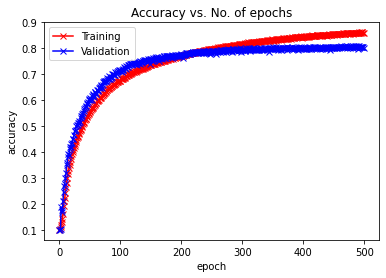

In [19]:
plot_accuracies(train_acclist, valid_acclist)

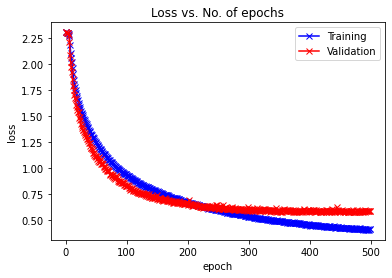

In [20]:
plot_losses(train_losslist, valid_losslist)

In [67]:
class CNN_remove_relu(nn.Module):
    
    def __init__(self):
        
        super(CNN_remove_relu, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(self.fc1(x)) # CNN_remove_relu
        x = self.dropout(self.fc2(x)) # CNN_remove_relu
        x = self.fc3(x)
        
        return x

In [68]:
class CNN_replace_pool_with_conv(nn.Module):
    
    def __init__(self):
        
        super(CNN_replace_pool_with_conv, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4 * 4 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.conv4(F.relu(self.conv1(x))) # replace_pool_with_conv
        x = self.conv5(F.relu(self.conv2(x))) # replace_pool_with_conv
        x = self.conv6(F.relu(self.conv3(x))) # replace_pool_with_conv
        x = self.dropout(x)
        # flattening
        x = x.view(-1, 64 * 4 * 4 * 4 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [69]:
def train_disabled_model(model, name, epoch_num):
    # specify loss function
    criterion = nn.CrossEntropyLoss()
    # specify optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    train_losslist = []
    valid_losslist = []
    train_acclist = []
    valid_acclist = []

    for epoch in range(1, epoch_num+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0

        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            acc = accuracy(output, target)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            train_acc += acc.item()*data.size(0)

        model.eval()
        for data, target in test_loader:
            output = model(data)
            acc = accuracy(output, target)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            valid_acc += acc.item()*data.size(0)

        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset)
        train_acc = train_acc/len(train_loader.dataset)
        valid_acc = valid_acc/len(test_loader.dataset)
        train_losslist.append(train_loss)
        valid_losslist.append(valid_loss)
        train_acclist.append(train_acc)
        valid_acclist.append(valid_acc)

        print("Epoch ->", epoch, "\t train_loss ->", train_loss, "\t\t\t train_acc ->", train_acc, 
              "\n==========\t valid_loss ->", valid_loss, "\t\t\t valid_acc ->", valid_acc)

    torch.save(model.state_dict(), 'cifar_' + name + '.pt')
    return train_acclist, valid_acclist, train_losslist, valid_losslist

In [70]:
train_acclist, valid_acclist, train_losslist, valid_losslist = train_disabled_model(CNN_remove_relu(), "remove_relu", epoch_num=500)

Epoch -> 1 	 train_loss -> 2.302084445953369 			 train_acc -> 0.11057999999046325 
==========	 valid_loss -> 2.295671237182617 			 valid_acc -> 0.1295
Epoch -> 2 	 train_loss -> 2.2824460083770752 			 train_acc -> 0.15085999999523164 
==========	 valid_loss -> 2.2439680427551267 			 valid_acc -> 0.2005
Epoch -> 3 	 train_loss -> 2.1749305667114256 			 train_acc -> 0.20812000000953673 
==========	 valid_loss -> 2.071729606628418 			 valid_acc -> 0.276
Epoch -> 4 	 train_loss -> 2.0677571823120116 			 train_acc -> 0.24614000000953673 
==========	 valid_loss -> 1.975285669898987 			 valid_acc -> 0.3029
Epoch -> 5 	 train_loss -> 1.9855290863800048 			 train_acc -> 0.2753199999952316 
==========	 valid_loss -> 1.882412857055664 			 valid_acc -> 0.334
Epoch -> 6 	 train_loss -> 1.9043638024139404 			 train_acc -> 0.30642000000953673 
==========	 valid_loss -> 1.8036421081542968 			 valid_acc -> 0.3624
Epoch -> 7 	 train_loss -> 1.8092079050064087 			 train_acc -> 0.33674 
==========	 valid_

Epoch -> 56 	 train_loss -> 0.9880905685424805 			 train_acc -> 0.6538599999809265 
==========	 valid_loss -> 0.9137151100158691 			 valid_acc -> 0.6762
Epoch -> 57 	 train_loss -> 0.9840737362670898 			 train_acc -> 0.655219999961853 
==========	 valid_loss -> 0.8916608179092407 			 valid_acc -> 0.6959
Epoch -> 58 	 train_loss -> 0.9808173448371887 			 train_acc -> 0.6584399999809265 
==========	 valid_loss -> 0.8667716175079345 			 valid_acc -> 0.7029
Epoch -> 59 	 train_loss -> 0.9767482973098754 			 train_acc -> 0.658439999961853 
==========	 valid_loss -> 0.8739817313194275 			 valid_acc -> 0.6986
Epoch -> 60 	 train_loss -> 0.9700353923034668 			 train_acc -> 0.660559999961853 
==========	 valid_loss -> 0.8677141527175903 			 valid_acc -> 0.7015
Epoch -> 61 	 train_loss -> 0.9657114109802246 			 train_acc -> 0.6610799999618531 
==========	 valid_loss -> 0.8689625426769256 			 valid_acc -> 0.6987
Epoch -> 62 	 train_loss -> 0.9598522492599487 			 train_acc -> 0.66684 
==========	 

Epoch -> 111 	 train_loss -> 0.7886757090759278 			 train_acc -> 0.724780000038147 
==========	 valid_loss -> 0.7165730506420136 			 valid_acc -> 0.752
Epoch -> 112 	 train_loss -> 0.7841806206893921 			 train_acc -> 0.729219999961853 
==========	 valid_loss -> 0.7287790463447571 			 valid_acc -> 0.7492
Epoch -> 113 	 train_loss -> 0.7805278392410279 			 train_acc -> 0.72936 
==========	 valid_loss -> 0.7133304616928101 			 valid_acc -> 0.7566
Epoch -> 114 	 train_loss -> 0.782402954120636 			 train_acc -> 0.727199999961853 
==========	 valid_loss -> 0.7186920841217042 			 valid_acc -> 0.7543
Epoch -> 115 	 train_loss -> 0.7847724398994446 			 train_acc -> 0.729179999961853 
==========	 valid_loss -> 0.7243338253974915 			 valid_acc -> 0.7475
Epoch -> 116 	 train_loss -> 0.7722761490058899 			 train_acc -> 0.7336 
==========	 valid_loss -> 0.7185267150878907 			 valid_acc -> 0.7559
Epoch -> 117 	 train_loss -> 0.7750047996425629 			 train_acc -> 0.732439999961853 
==========	 valid_los

Epoch -> 166 	 train_loss -> 0.7012646819877625 			 train_acc -> 0.7565599999618531 
==========	 valid_loss -> 0.6797230979442597 			 valid_acc -> 0.7691
Epoch -> 167 	 train_loss -> 0.703061960887909 			 train_acc -> 0.7538000000190734 
==========	 valid_loss -> 0.6746934079170227 			 valid_acc -> 0.7704
Epoch -> 168 	 train_loss -> 0.6960948276138306 			 train_acc -> 0.76114 
==========	 valid_loss -> 0.6827008299350739 			 valid_acc -> 0.7648
Epoch -> 169 	 train_loss -> 0.6972865825653076 			 train_acc -> 0.757600000038147 
==========	 valid_loss -> 0.6714541085243225 			 valid_acc -> 0.7717
Epoch -> 170 	 train_loss -> 0.6987108112335205 			 train_acc -> 0.7578599999809266 
==========	 valid_loss -> 0.7083980831623078 			 valid_acc -> 0.7542
Epoch -> 171 	 train_loss -> 0.69959153881073 			 train_acc -> 0.757159999961853 
==========	 valid_loss -> 0.6706112432479858 			 valid_acc -> 0.7716
Epoch -> 172 	 train_loss -> 0.7001707568359375 			 train_acc -> 0.755599999961853 
========

Epoch -> 221 	 train_loss -> 0.6549618152046204 			 train_acc -> 0.7723799999809265 
==========	 valid_loss -> 0.7059248489379882 			 valid_acc -> 0.7534
Epoch -> 222 	 train_loss -> 0.6490325487422943 			 train_acc -> 0.7757999999809265 
==========	 valid_loss -> 0.6787454797744751 			 valid_acc -> 0.7677
Epoch -> 223 	 train_loss -> 0.6502619030952453 			 train_acc -> 0.77448 
==========	 valid_loss -> 0.6533567472457886 			 valid_acc -> 0.7774
Epoch -> 224 	 train_loss -> 0.6513119681549072 			 train_acc -> 0.774180000038147 
==========	 valid_loss -> 0.660482541847229 			 valid_acc -> 0.7761
Epoch -> 225 	 train_loss -> 0.6428466679191589 			 train_acc -> 0.7750199999809265 
==========	 valid_loss -> 0.6722204643249512 			 valid_acc -> 0.772
Epoch -> 226 	 train_loss -> 0.6478725593948365 			 train_acc -> 0.7738800000190735 
==========	 valid_loss -> 0.6659844703674317 			 valid_acc -> 0.7694
Epoch -> 227 	 train_loss -> 0.6474229273796082 			 train_acc -> 0.77312 
==========	 vali

Epoch -> 276 	 train_loss -> 0.6172516933059692 			 train_acc -> 0.783159999961853 
==========	 valid_loss -> 0.6630299663543702 			 valid_acc -> 0.7798
Epoch -> 277 	 train_loss -> 0.6182468906784058 			 train_acc -> 0.7836599999809265 
==========	 valid_loss -> 0.6624393887519836 			 valid_acc -> 0.7748
Epoch -> 278 	 train_loss -> 0.6259181693840027 			 train_acc -> 0.783900000038147 
==========	 valid_loss -> 0.6533127195835113 			 valid_acc -> 0.7763
Epoch -> 279 	 train_loss -> 0.6190139051437378 			 train_acc -> 0.784020000038147 
==========	 valid_loss -> 0.6678957006931305 			 valid_acc -> 0.7736
Epoch -> 280 	 train_loss -> 0.6196468398284912 			 train_acc -> 0.783620000038147 
==========	 valid_loss -> 0.6600277123451233 			 valid_acc -> 0.7806
Epoch -> 281 	 train_loss -> 0.6144890563583374 			 train_acc -> 0.78552 
==========	 valid_loss -> 0.6632878550052643 			 valid_acc -> 0.7764
Epoch -> 282 	 train_loss -> 0.6162001474189759 			 train_acc -> 0.7840800000381469 
======

Epoch -> 331 	 train_loss -> 0.5960108099174499 			 train_acc -> 0.7927199999809265 
==========	 valid_loss -> 0.6890629656791687 			 valid_acc -> 0.7673
Epoch -> 332 	 train_loss -> 0.5997436135482788 			 train_acc -> 0.790099999961853 
==========	 valid_loss -> 0.6797576360225678 			 valid_acc -> 0.7708
Epoch -> 333 	 train_loss -> 0.6009346885490418 			 train_acc -> 0.789580000038147 
==========	 valid_loss -> 0.6946248428344727 			 valid_acc -> 0.7629
Epoch -> 334 	 train_loss -> 0.6007546633720398 			 train_acc -> 0.79136 
==========	 valid_loss -> 0.6719200451850891 			 valid_acc -> 0.7741
Epoch -> 335 	 train_loss -> 0.5991039545059204 			 train_acc -> 0.7904 
==========	 valid_loss -> 0.7038783423423767 			 valid_acc -> 0.7595
Epoch -> 336 	 train_loss -> 0.6001654105377198 			 train_acc -> 0.78834 
==========	 valid_loss -> 0.654594863986969 			 valid_acc -> 0.776
Epoch -> 337 	 train_loss -> 0.5957823225021363 			 train_acc -> 0.7909799999809265 
==========	 valid_loss -> 0.6

Epoch -> 386 	 train_loss -> 0.5823833619880676 			 train_acc -> 0.7971799999618531 
==========	 valid_loss -> 0.662164135169983 			 valid_acc -> 0.7767
Epoch -> 387 	 train_loss -> 0.5824698810577392 			 train_acc -> 0.796640000038147 
==========	 valid_loss -> 0.665982668685913 			 valid_acc -> 0.7754
Epoch -> 388 	 train_loss -> 0.5774503960609436 			 train_acc -> 0.7994000000381469 
==========	 valid_loss -> 0.673080476140976 			 valid_acc -> 0.7741
Epoch -> 389 	 train_loss -> 0.5840490006351471 			 train_acc -> 0.7954000000190735 
==========	 valid_loss -> 0.6614426084518432 			 valid_acc -> 0.7808
Epoch -> 390 	 train_loss -> 0.5791302785110474 			 train_acc -> 0.797600000038147 
==========	 valid_loss -> 0.6575103378295899 			 valid_acc -> 0.7797
Epoch -> 391 	 train_loss -> 0.5870544450378418 			 train_acc -> 0.7948000000190735 
==========	 valid_loss -> 0.6609193446397781 			 valid_acc -> 0.7768
Epoch -> 392 	 train_loss -> 0.5829420035362244 			 train_acc -> 0.79824 
=======

Epoch -> 441 	 train_loss -> 0.5655140675258636 			 train_acc -> 0.80134 
==========	 valid_loss -> 0.6568401430130005 			 valid_acc -> 0.7847
Epoch -> 442 	 train_loss -> 0.5663805698776245 			 train_acc -> 0.802199999961853 
==========	 valid_loss -> 0.6613014478683472 			 valid_acc -> 0.7794
Epoch -> 443 	 train_loss -> 0.5767003203392029 			 train_acc -> 0.79832 
==========	 valid_loss -> 0.6665181587219239 			 valid_acc -> 0.7749
Epoch -> 444 	 train_loss -> 0.5644725143814087 			 train_acc -> 0.802799999961853 
==========	 valid_loss -> 0.6609457692146301 			 valid_acc -> 0.7741
Epoch -> 445 	 train_loss -> 0.566755791091919 			 train_acc -> 0.80214 
==========	 valid_loss -> 0.6652622985839843 			 valid_acc -> 0.7787
Epoch -> 446 	 train_loss -> 0.5703792557907105 			 train_acc -> 0.79956 
==========	 valid_loss -> 0.6725221263885498 			 valid_acc -> 0.7773
Epoch -> 447 	 train_loss -> 0.5677543198013306 			 train_acc -> 0.7991200000190735 
==========	 valid_loss -> 0.6566603100

Epoch -> 496 	 train_loss -> 0.5587810415840149 			 train_acc -> 0.8034000000381469 
==========	 valid_loss -> 0.6574981973648071 			 valid_acc -> 0.7843
Epoch -> 497 	 train_loss -> 0.5594558310890198 			 train_acc -> 0.806080000038147 
==========	 valid_loss -> 0.6703951228141785 			 valid_acc -> 0.7777
Epoch -> 498 	 train_loss -> 0.5614323957061768 			 train_acc -> 0.8046199999809265 
==========	 valid_loss -> 0.6662565372467041 			 valid_acc -> 0.7827
Epoch -> 499 	 train_loss -> 0.5520958460998535 			 train_acc -> 0.807820000038147 
==========	 valid_loss -> 0.6756238569259644 			 valid_acc -> 0.7704
Epoch -> 500 	 train_loss -> 0.5530544519996643 			 train_acc -> 0.8049 
==========	 valid_loss -> 0.7137349595069885 			 valid_acc -> 0.7637


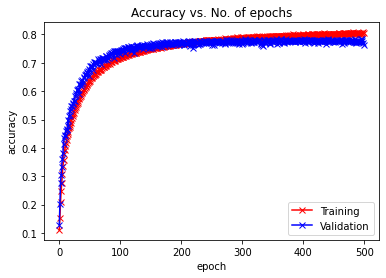

In [71]:
plot_accuracies(train_acclist, valid_acclist)

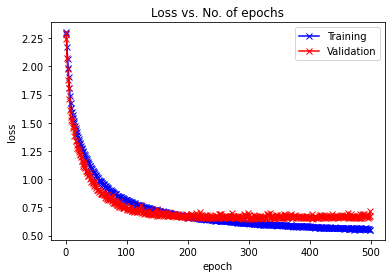

In [72]:
plot_losses(train_losslist, valid_losslist)

In [73]:
train_acclist, valid_acclist, train_losslist, valid_losslist = train_disabled_model(CNN_replace_pool_with_conv(), 
                                                                                    "replace_pool_with_conv", epoch_num=375)

Epoch -> 1 	 train_loss -> 2.304023597793579 			 train_acc -> 0.10124 
==========	 valid_loss -> 2.302445506286621 			 valid_acc -> 0.1
Epoch -> 2 	 train_loss -> 2.30159229095459 			 train_acc -> 0.11186000000238419 
==========	 valid_loss -> 2.297505780029297 			 valid_acc -> 0.1527
Epoch -> 3 	 train_loss -> 2.25628015663147 			 train_acc -> 0.16437999999046327 
==========	 valid_loss -> 2.1152838871002198 			 valid_acc -> 0.235
Epoch -> 4 	 train_loss -> 2.066243643836975 			 train_acc -> 0.23495999999046327 
==========	 valid_loss -> 1.9255500032424926 			 valid_acc -> 0.298
Epoch -> 5 	 train_loss -> 1.968113205871582 			 train_acc -> 0.2796199999809265 
==========	 valid_loss -> 1.8681464605331422 			 valid_acc -> 0.33
Epoch -> 6 	 train_loss -> 1.897044430770874 			 train_acc -> 0.30962 
==========	 valid_loss -> 1.786969020462036 			 valid_acc -> 0.3552
Epoch -> 7 	 train_loss -> 1.8282855856704712 			 train_acc -> 0.3282000000190735 
==========	 valid_loss -> 1.70767085380554

Epoch -> 56 	 train_loss -> 0.5436684313297272 			 train_acc -> 0.81036 
==========	 valid_loss -> 1.1260452131271361 			 valid_acc -> 0.6666
Epoch -> 57 	 train_loss -> 0.5216561289215088 			 train_acc -> 0.8173800000381469 
==========	 valid_loss -> 1.0978241724967956 			 valid_acc -> 0.6658
Epoch -> 58 	 train_loss -> 0.5034173562622071 			 train_acc -> 0.824760000038147 
==========	 valid_loss -> 1.0949876181602478 			 valid_acc -> 0.6642
Epoch -> 59 	 train_loss -> 0.4845261086273193 			 train_acc -> 0.8301600000190735 
==========	 valid_loss -> 1.1232545197486878 			 valid_acc -> 0.6609
Epoch -> 60 	 train_loss -> 0.46435440965652464 			 train_acc -> 0.83714 
==========	 valid_loss -> 1.073545645904541 			 valid_acc -> 0.6805
Epoch -> 61 	 train_loss -> 0.4531749039077759 			 train_acc -> 0.8446799999809265 
==========	 valid_loss -> 1.0856607026100158 			 valid_acc -> 0.6694
Epoch -> 62 	 train_loss -> 0.4450075557231903 			 train_acc -> 0.8464199999809265 
==========	 valid_los

Epoch -> 111 	 train_loss -> 0.1326733765721321 			 train_acc -> 0.956460000038147 
==========	 valid_loss -> 1.76516616191864 			 valid_acc -> 0.6923
Epoch -> 112 	 train_loss -> 0.1292202656364441 			 train_acc -> 0.958019999961853 
==========	 valid_loss -> 1.6706185119628907 			 valid_acc -> 0.6913
Epoch -> 113 	 train_loss -> 0.12508836969852447 			 train_acc -> 0.9592600000190735 
==========	 valid_loss -> 1.82484234085083 			 valid_acc -> 0.6945
Epoch -> 114 	 train_loss -> 0.12587943727016448 			 train_acc -> 0.95998 
==========	 valid_loss -> 1.7884910451889038 			 valid_acc -> 0.6914
Epoch -> 115 	 train_loss -> 0.12494635136842727 			 train_acc -> 0.9590399999618531 
==========	 valid_loss -> 1.5370623580932616 			 valid_acc -> 0.6933
Epoch -> 116 	 train_loss -> 0.12289411725401879 			 train_acc -> 0.9608000000190735 
==========	 valid_loss -> 1.764051905822754 			 valid_acc -> 0.6976
Epoch -> 117 	 train_loss -> 0.1255966585469246 			 train_acc -> 0.9590600000190734 
=====

Epoch -> 166 	 train_loss -> 0.0737976959168911 			 train_acc -> 0.9764000000190735 
==========	 valid_loss -> 2.025974880027771 			 valid_acc -> 0.7015
Epoch -> 167 	 train_loss -> 0.07145860824108123 			 train_acc -> 0.9777 
==========	 valid_loss -> 1.8089193363189697 			 valid_acc -> 0.6993
Epoch -> 168 	 train_loss -> 0.07087813180565834 			 train_acc -> 0.9768400000190735 
==========	 valid_loss -> 2.03133692817688 			 valid_acc -> 0.7005
Epoch -> 169 	 train_loss -> 0.07493916048288346 			 train_acc -> 0.976100000038147 
==========	 valid_loss -> 1.928709156227112 			 valid_acc -> 0.6979
Epoch -> 170 	 train_loss -> 0.07184828515172005 			 train_acc -> 0.9777199999809265 
==========	 valid_loss -> 1.7840593818664552 			 valid_acc -> 0.698
Epoch -> 171 	 train_loss -> 0.0694303442710638 			 train_acc -> 0.9779600000190735 
==========	 valid_loss -> 2.1457026481628416 			 valid_acc -> 0.7019
Epoch -> 172 	 train_loss -> 0.07089701800346375 			 train_acc -> 0.9771200000381469 
====

Epoch -> 221 	 train_loss -> 0.0523583794426918 			 train_acc -> 0.9835000000190735 
==========	 valid_loss -> 2.252824802780151 			 valid_acc -> 0.7082
Epoch -> 222 	 train_loss -> 0.0490582038974762 			 train_acc -> 0.984520000038147 
==========	 valid_loss -> 2.129251865386963 			 valid_acc -> 0.7066
Epoch -> 223 	 train_loss -> 0.04791351009875536 			 train_acc -> 0.98364 
==========	 valid_loss -> 1.9767278042793275 			 valid_acc -> 0.7022
Epoch -> 224 	 train_loss -> 0.050080282111167905 			 train_acc -> 0.984300000038147 
==========	 valid_loss -> 2.7078547813415526 			 valid_acc -> 0.6824
Epoch -> 225 	 train_loss -> 0.05009176229715347 			 train_acc -> 0.9839600000190735 
==========	 valid_loss -> 2.1750537040710447 			 valid_acc -> 0.7025
Epoch -> 226 	 train_loss -> 0.056193304941654205 			 train_acc -> 0.9827000000190735 
==========	 valid_loss -> 1.7871316703796387 			 valid_acc -> 0.699
Epoch -> 227 	 train_loss -> 0.05037701006650925 			 train_acc -> 0.984260000038147 
=

Epoch -> 276 	 train_loss -> 0.044714683622419836 			 train_acc -> 0.98602 
==========	 valid_loss -> 2.1803914470672607 			 valid_acc -> 0.7044
Epoch -> 277 	 train_loss -> 0.03986604805409908 			 train_acc -> 0.9873800000190734 
==========	 valid_loss -> 1.9138491188049316 			 valid_acc -> 0.7036
Epoch -> 278 	 train_loss -> 0.041444616156220436 			 train_acc -> 0.9866600000190735 
==========	 valid_loss -> 2.4441683302879333 			 valid_acc -> 0.7107
Epoch -> 279 	 train_loss -> 0.03909431937456131 			 train_acc -> 0.9877200000190735 
==========	 valid_loss -> 2.320745645284653 			 valid_acc -> 0.6958
Epoch -> 280 	 train_loss -> 0.03988637029230595 			 train_acc -> 0.9871400000190735 
==========	 valid_loss -> 2.0904035514831545 			 valid_acc -> 0.7082
Epoch -> 281 	 train_loss -> 0.04014303686350584 			 train_acc -> 0.9875600000190735 
==========	 valid_loss -> 2.1149692253112793 			 valid_acc -> 0.703
Epoch -> 282 	 train_loss -> 0.03897576371490955 			 train_acc -> 0.9878 
=======

Epoch -> 331 	 train_loss -> 0.03205818050533533 			 train_acc -> 0.98966 
==========	 valid_loss -> 2.296070124053955 			 valid_acc -> 0.7084
Epoch -> 332 	 train_loss -> 0.03312926595956087 			 train_acc -> 0.9896 
==========	 valid_loss -> 2.4375612117767336 			 valid_acc -> 0.7079
Epoch -> 333 	 train_loss -> 0.03086057514667511 			 train_acc -> 0.9899000000190735 
==========	 valid_loss -> 2.108242448425293 			 valid_acc -> 0.7059
Epoch -> 334 	 train_loss -> 0.036338984633982184 			 train_acc -> 0.98848 
==========	 valid_loss -> 2.6320456813812254 			 valid_acc -> 0.7035
Epoch -> 335 	 train_loss -> 0.03362475864470005 			 train_acc -> 0.9892400000190735 
==========	 valid_loss -> 2.5248395053625106 			 valid_acc -> 0.712
Epoch -> 336 	 train_loss -> 0.036269686637818814 			 train_acc -> 0.9888600000190735 
==========	 valid_loss -> 2.1802462463378904 			 valid_acc -> 0.7116
Epoch -> 337 	 train_loss -> 0.03417246083319187 			 train_acc -> 0.98898 
==========	 valid_loss -> 2.40

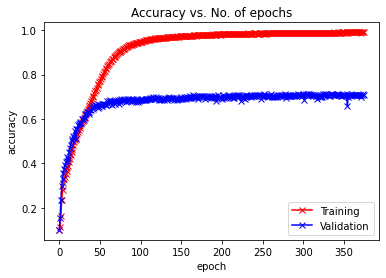

In [74]:
plot_accuracies(train_acclist, valid_acclist)

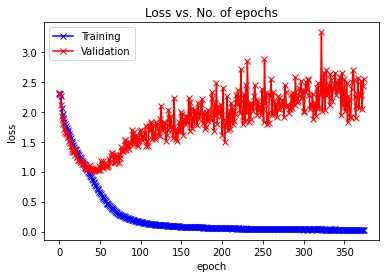

In [75]:
plot_losses(train_losslist, valid_losslist)

In [76]:
class CNN(nn.Module):
   
    def __init__(self):
        
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)

        return x

In [77]:
model = CNN()
print(model)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout2d(p=0.3, inplace=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout2d(p=0.3, inplace=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, mome

In [78]:
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
train_losslist = []
valid_losslist = []
train_acclist = []
valid_acclist = []

for epoch in range(1, 500+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0

    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        acc = accuracy(output, target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        train_acc += acc.item()*data.size(0)

    model.eval()
    for data, target in test_loader:
        output = model(data)
        acc = accuracy(output, target)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        valid_acc += acc.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    train_acc = train_acc/len(train_loader.dataset)
    valid_acc = valid_acc/len(test_loader.dataset)
    train_losslist.append(train_loss)
    valid_losslist.append(valid_loss)
    train_acclist.append(train_acc)
    valid_acclist.append(valid_acc)
        
    print("Epoch ->", epoch, "\t train_loss ->", train_loss, "\t\t\t train_acc ->", train_acc, 
          "\n==========\t valid_loss ->", valid_loss, "\t\t\t valid_acc ->", valid_acc)
    
torch.save(model.state_dict(), 'cifar_cnn.pt')

Epoch -> 1 	 train_loss -> 2.2737589458465575 			 train_acc -> 0.13296000000953676 
==========	 valid_loss -> 2.1566292919158934 			 valid_acc -> 0.2567
Epoch -> 2 	 train_loss -> 1.9479206214141846 			 train_acc -> 0.26708000000953674 
==========	 valid_loss -> 1.7200027795791626 			 valid_acc -> 0.3392
Epoch -> 3 	 train_loss -> 1.7142098293304444 			 train_acc -> 0.3526200000190735 
==========	 valid_loss -> 1.5643112918853759 			 valid_acc -> 0.4143
Epoch -> 4 	 train_loss -> 1.5917490731430053 			 train_acc -> 0.4039599999809265 
==========	 valid_loss -> 1.4399601543426515 			 valid_acc -> 0.4693
Epoch -> 5 	 train_loss -> 1.5010619089508057 			 train_acc -> 0.44078 
==========	 valid_loss -> 1.340114263534546 			 valid_acc -> 0.5102
Epoch -> 6 	 train_loss -> 1.4151564876174927 			 train_acc -> 0.47481999999046326 
==========	 valid_loss -> 1.2555481491088867 			 valid_acc -> 0.5435
Epoch -> 7 	 train_loss -> 1.3339846011352539 			 train_acc -> 0.5097199999809265 
==========	 va

Epoch -> 56 	 train_loss -> 0.46653962009429933 			 train_acc -> 0.8379199999618531 
==========	 valid_loss -> 0.4879469892024994 			 valid_acc -> 0.8368
Epoch -> 57 	 train_loss -> 0.4630123673439026 			 train_acc -> 0.83776 
==========	 valid_loss -> 0.4886961735725403 			 valid_acc -> 0.8347
Epoch -> 58 	 train_loss -> 0.4534042796421051 			 train_acc -> 0.8423000000190735 
==========	 valid_loss -> 0.4797987856864929 			 valid_acc -> 0.8411
Epoch -> 59 	 train_loss -> 0.4528919867515564 			 train_acc -> 0.84378 
==========	 valid_loss -> 0.48449532330036166 			 valid_acc -> 0.8402
Epoch -> 60 	 train_loss -> 0.44297866342544556 			 train_acc -> 0.84596 
==========	 valid_loss -> 0.49196908292770386 			 valid_acc -> 0.8361
Epoch -> 61 	 train_loss -> 0.4419278963947296 			 train_acc -> 0.84706 
==========	 valid_loss -> 0.4893145360946655 			 valid_acc -> 0.8381
Epoch -> 62 	 train_loss -> 0.43498276968955996 			 train_acc -> 0.8499999999809266 
==========	 valid_loss -> 0.473221298

Epoch -> 111 	 train_loss -> 0.27075064816474914 			 train_acc -> 0.9045199999809265 
==========	 valid_loss -> 0.4545476492881775 			 valid_acc -> 0.8616
Epoch -> 112 	 train_loss -> 0.2645494798374176 			 train_acc -> 0.908320000038147 
==========	 valid_loss -> 0.4557991101264954 			 valid_acc -> 0.8632
Epoch -> 113 	 train_loss -> 0.26177826268672943 			 train_acc -> 0.9085600000190734 
==========	 valid_loss -> 0.4520764623641968 			 valid_acc -> 0.863
Epoch -> 114 	 train_loss -> 0.26226947272777557 			 train_acc -> 0.908559999961853 
==========	 valid_loss -> 0.46456990265846254 			 valid_acc -> 0.8577
Epoch -> 115 	 train_loss -> 0.25152579978466033 			 train_acc -> 0.9126 
==========	 valid_loss -> 0.45611673154830934 			 valid_acc -> 0.8594
Epoch -> 116 	 train_loss -> 0.25836509117126466 			 train_acc -> 0.910459999961853 
==========	 valid_loss -> 0.47223542084544895 			 valid_acc -> 0.8585
Epoch -> 117 	 train_loss -> 0.25207799946784976 			 train_acc -> 0.9106799999809265

Epoch -> 165 	 train_loss -> 0.17872129398107528 			 train_acc -> 0.938240000038147 
==========	 valid_loss -> 0.4662711214065552 			 valid_acc -> 0.8664
Epoch -> 166 	 train_loss -> 0.17721121161460876 			 train_acc -> 0.9382200000190735 
==========	 valid_loss -> 0.47821931475400925 			 valid_acc -> 0.8684
Epoch -> 167 	 train_loss -> 0.17618400016546248 			 train_acc -> 0.9380600000381469 
==========	 valid_loss -> 0.46978635063171387 			 valid_acc -> 0.8714
Epoch -> 168 	 train_loss -> 0.17518787620067597 			 train_acc -> 0.93868 
==========	 valid_loss -> 0.46718188799619675 			 valid_acc -> 0.8717
Epoch -> 169 	 train_loss -> 0.17161264007568358 			 train_acc -> 0.9393799999809265 
==========	 valid_loss -> 0.47041587953567504 			 valid_acc -> 0.8705
Epoch -> 170 	 train_loss -> 0.17115960494995117 			 train_acc -> 0.939519999961853 
==========	 valid_loss -> 0.46329340648651124 			 valid_acc -> 0.869
Epoch -> 171 	 train_loss -> 0.16781429862737657 			 train_acc -> 0.94114000001

In [ ]:
plot_accuracies(train_acclist, valid_acclist)

In [ ]:
plot_losses(train_losslist, valid_losslist)

In [ ]:
CNN 80% ???

# End